In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#helper functions
def int2analog(x, n=10):
    # Convert an integer to a PyTorch tensor
    x_tensor = torch.tensor([x], dtype=torch.int32)

    # Convert integers into the corresponding binary bits.
    shifts = torch.arange(n - 1, -1, -1, dtype=x_tensor.dtype)
    x_tensor = torch.bitwise_right_shift(x_tensor, shifts)
    x_tensor = torch.remainder(x_tensor, 2)

    # Convert the binary bits into the corresponding analog values.
    x_tensor = x_tensor.type(torch.float32)
    x_tensor = 2 * x_tensor - 1


    return x_tensor  

def analog2int(x):
    # Convert an analog bit representation back to an integer
    x = (x + 1) / 2  # Convert from [-1, 1] to [0, 1]
    x = torch.round(x).type(torch.int32)  # Round and convert to int
    # Convert binary bits back to integer
    int_val = 0
    for i, bit in enumerate(reversed(x)):
        int_val += bit.item() * (2 ** i)
    return int_val


## Dataset Generation for Binary Sequences Toy Example
The dataset is designed to consist of binary sequences with a specific structure and controlled noise. It's generated using the generate_binary_dataset function, which allows for customization in terms of size, noise levels, and dataset splits.

Structure of the Sequences
The core of the dataset comprises two types of binary sequences:

#### 11110000
#### 00001111
Each sequence is an 8-bit binary pattern, with the first type having the first four bits set to 1 and the last four to 0, and the second type being its inverse.

Noise Introduction
Noise is introduced to these sequences to simulate real-world imperfections or variations. The level and probability of noise can be adjusted:

Noise Level (noise_level): Determines the number of bits to flip in each sequence. This is capped at 8, the length of the sequences.
Noise Probability (noise_prob): The likelihood of any bit being flipped in a sequence.
This mechanism ensures that the dataset doesn't just contain pristine, predictable patterns, but rather includes realistic variations

In [35]:
import numpy as np
import torch
import random

def generate_binary_dataset_with_conditions(size, noise_level=1, noise_prob=0.2, train_split=0.7, test_split=0.3, validation_split=0.0):
    """
    Generates a dataset with binary sequences "11110000" and "00001111", 
    with a specified level of noise. Each sequence is paired with a condition label.
    Splits the dataset into training and testing sets.

    Args:
    - size (int): Number of samples to generate.
    - noise_level (int): Number of bits to flip for adding noise.
    - noise_prob (float): Probability of flipping a bit.
    - train_split (float): Fraction of the dataset to be used for training.
    - test_split (float): Fraction of the dataset to be used for testing.

    Returns:
    - tuple: (train_set, test_set), where each set contains pairs of (sequence, condition)
    """

    if train_split + test_split > 1:
        raise ValueError("Sum of splits must not exceed 1.")

    # Two base patterns and their labels
    pattern1 = np.array([1, 1, 1, 1, 0, 0, 0, 0])
    pattern2 = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    label1 = 0
    label2 = 1

    # Initialize dataset and labels
    dataset = []
    labels = []

    for i in range(size):
        # Choose a base pattern and its label for each sample
        if np.random.rand() > 0.5:
            pattern, label = pattern1, label1
        else:
            pattern, label = pattern2, label2

        # Add noise
        noisy_pattern = pattern.copy()
        if random.random() < noise_prob:
            noise_indices = np.random.choice(8, noise_level, replace=False)
            noisy_pattern[noise_indices] = 1 - noisy_pattern[noise_indices]
        
        dataset.append(noisy_pattern)
        labels.append(label)

    # Convert dataset and labels to PyTorch tensors
    dataset = torch.tensor(dataset, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Calculate split sizes
    train_size = int(size * train_split)
    test_size = int(size * test_split)
    validation_size = size - train_size - test_size

    # Split the dataset
    train_set = dataset[:train_size]
    test_set = dataset[train_size:train_size + test_size]
    validation_set = dataset[train_size + test_size:] if validation_split > 0 else None

    # Split the labels
    train_labels = labels[:train_size]
    test_labels = labels[train_size:train_size + test_size]
    validation_labels = labels[train_size + test_size:] if validation_split > 0 else None

    # Combine the dataset and labels into tuples
    train_set = list(zip(train_set, train_labels))
    test_set = list(zip(test_set, test_labels))
    validation_set = list(zip(validation_set, validation_labels)) if validation_split > 0 else None

    return train_set, test_set, validation_set



# Conver dataset values from 0/1 to -1/1 and condition values from 0/1 to -1/1
def convert_dataset(dataset):
    converted_dataset = []
    for sequence, condition in dataset:
        sequence = 2 * sequence - 1
        converted_dataset.append((sequence, condition))
    return converted_dataset


def prepare_data_loader(dataset, batch_size):
    # Separate sequences and conditions
    sequences, conditions = zip(*dataset)
    sequences = torch.stack(sequences)
    conditions = torch.stack(conditions)

    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(sequences, conditions)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader




# Example usage
size = 10000  # Total number of samples
train_set, test_set, val = generate_binary_dataset_with_conditions(size)
train_loader = prepare_data_loader(train_set, batch_size=32)
test_loader = prepare_data_loader(test_set, batch_size=32)




#### Dataset Demonstration

In [36]:
# Generate a dataset with 1000 samples and noise prob 0.2
train_set, test_set, validation_set = generate_binary_dataset_with_conditions(10000, noise_prob=0.05)





In [37]:
def byte2analog(x):
    """
    Converts a byte to an analog signal.

    Args:
    - x (torch.Tensor): A tensor of shape (8,) representing a byte.

    Returns:
    - torch.Tensor: A tensor of shape (8,) representing an analog signal.
    """

    # Convert to float
    x = x.float()

    # Scale to [-1, 1]
    x = 2 * x - 1

    return x
    

### Corruption Process and Noise Schedule

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. To save time, there is a faster formula that computes all the timesteps simultaneously: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>


In [38]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Generates a cosine noise schedule.

    Args:
    - timesteps (int): The total number of timesteps.
    - s (float): Scale factor for the noise level.

    Returns:
    - torch.Tensor: The beta schedule tensor.
    """
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    beta_schedule = s * (1 + torch.cos(torch.pi * steps)) / 2
    return beta_schedule

def compute_alpha_bar(beta_schedule):
    alpha = 1. - beta_schedule
    alpha_bar = torch.cumprod(alpha, dim=0)
    return alpha, alpha_bar

def apply_noise(x, timestep, beta_schedule):
    """
    Applies noise to an image x at a specific timestep.

    Args:
    - x (torch.Tensor): The initial image tensor.
    - timestep (int): The specific timestep at which to apply noise.
    - beta_schedule (torch.Tensor): The beta schedule tensor.

    Returns:
    - torch.Tensor: The noised version of the image at the specified timestep.
    """
    # Compute alpha and alpha_bar
    alpha, alpha_bar = compute_alpha_bar(beta_schedule)

    # Ensure the timestep is within the range of the beta schedule
    if timestep >= beta_schedule.size(0):
        raise ValueError("Timestep is out of range of the beta schedule")

    # Add noise to the image at the specified timestep
    epsilon = torch.randn_like(x)
    xt = torch.sqrt(alpha_bar[timestep]) * x + torch.sqrt(1. - alpha_bar[timestep]) * epsilon

    return xt

# Example usage
T = 1000  # Number of timesteps
beta_schedule = torch.linspace(1e-4, 0.02, T)  # Example beta schedule
x0 = torch.tensor([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0])

# Apply noise recurseively for T timesteps
x_to_plot = []
xt = x0
for t in range(T):
    xt = apply_noise(xt, t, beta_schedule)
    if t % 100 == 0:
        print("Timestep:", t, end=" | ")
        print("xt:", xt)
        x_to_plot.append(xt)




Timestep: 0 | xt: tensor([ 1.0026,  1.0154, -0.9973, -1.0071, -1.0075, -1.0074, -1.0200,  0.9909])
Timestep: 100 | xt: tensor([ 1.3788,  1.3334, -0.0857, -2.8321, -0.5267, -0.5085,  1.3309, -0.0035])
Timestep: 200 | xt: tensor([ 1.4377,  0.0238, -0.1157,  0.3734, -0.4587, -1.4220, -0.6118, -0.8285])
Timestep: 300 | xt: tensor([ 0.7804, -0.3118,  0.4918,  0.3602,  0.9978, -0.5209, -0.2101, -0.1252])
Timestep: 400 | xt: tensor([ 1.4615, -0.6720, -0.3258, -0.0235, -0.5232, -0.7609, -0.0334, -0.7421])
Timestep: 500 | xt: tensor([-1.3872, -0.1936,  1.2533, -1.2693, -0.2322,  0.0482, -0.7939,  1.1548])
Timestep: 600 | xt: tensor([-0.5325,  0.9762,  1.5682,  0.0950,  0.3306,  0.4395,  1.4572, -0.2877])
Timestep: 700 | xt: tensor([-1.7909, -1.1882,  0.1199,  0.4667, -0.7673,  2.4680, -0.0217, -0.3365])
Timestep: 800 | xt: tensor([ 1.0865,  1.4659, -0.3067, -0.3800,  0.3095,  0.5352, -0.4520, -0.8049])
Timestep: 900 | xt: tensor([-0.7598, -0.5201, -0.0523,  0.4550,  0.3438,  0.1482, -0.2589,  0

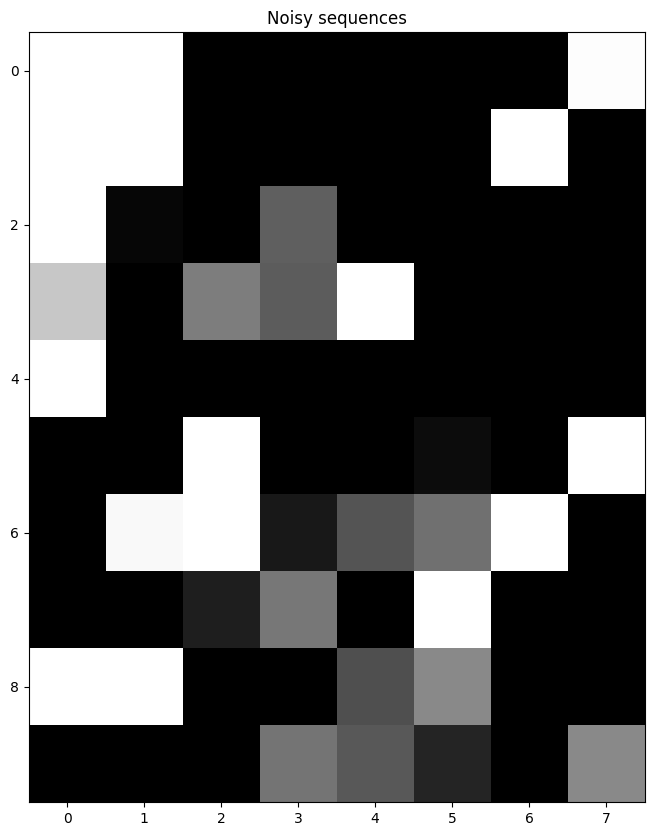

In [39]:
#visualize sequence as image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def visualize_sequence(sequence, title=""):
    """
    Visualizes a sequence as an image.

    Args:
    - sequence (torch.Tensor): A tensor of shape (8,) representing a sequence.
    - title (str): Title of the image.
    """

    # Convert sequence to a numpy array
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.cpu().detach().numpy()


    # Reshape sequence to (1, 8) and transpose it to (8, 1)
    sequence = sequence.reshape((8, 1)).T

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    sequence = np.clip(sequence, -1, 1)

    # Plot the noisy sequences
    plt.figure(figsize=(8, 1))
    plt.imshow(sequence, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.show()


# Example
#visualize_sequence(x0, title="x0")

#visualize 10 noisy sequences in a grid
def visualize_noisy_sequences(noisy_sequences, title=""):
    """
    Visualizes a list of noisy sequences as a 10x8 grid of images. Maps sequences from [-1, 1] to [0, 1] and clips values out of bounds.
    """
    # Convert noisy sequences to a numpy array
    noisy_sequences = [seq.numpy() for seq in noisy_sequences]

    # Reshape noisy sequences to a 10x8 grid
    noisy_sequences = np.array(noisy_sequences).reshape((10, 8))

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    noisy_sequences = np.clip(noisy_sequences, -1, 1)

    # Plot the noisy sequences
    plt.figure(figsize=(8, 10))
    plt.imshow(noisy_sequences, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.show()

def visualize_sequence_condition(sequence, condition, title=""):
    """
    Visualizes a sequence and its condition as an image.

    Args:
    - sequence (torch.Tensor): A tensor of shape (8,) representing a sequence.
    - condition (torch.Tensor): A tensor of shape (1,) representing a condition.
    - title (str): Title of the image.
    """

    # Convert sequence and condition to numpy arrays
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.cpu().detach().numpy()
    if isinstance(condition, torch.Tensor):
        condition = condition.cpu().detach().numpy()

    # Reshape sequence to (1, 8) and transpose it to (8, 1)
    sequence = sequence.reshape((8, 1)).T

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    sequence = np.clip(sequence, -1, 1)

    # Plot the noisy sequences
    plt.figure(figsize=(8, 1))
    plt.imshow(sequence, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel("Condition: " + str(condition))
    plt.show()



#get 10 noisy sequences throughout the whole sequence of 1000 timesteps

# Example
visualize_noisy_sequences(x_to_plot, title="Noisy sequences")
#print(noisy_sequences[:10])

## Diffusion Model Architecture

Inspired a U-Net but is much more simple given the simplicity of the dataset. ~1500 parameters. Hopefully it will be fairly straighforward to scale.



In [40]:
class ConditionalSimpleUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, condition_dim=1):
        super(ConditionalSimpleUNet, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim

        # Encoder
        self.enc1 = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        # Decoder
        self.dec1 = nn.Linear(hidden_dim // 2 + condition_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, condition):
        # Concatenate condition to input
        # print('x shape: ', x.shape)
        # print('condition shape: ', condition.shape)
        # print('condition: ', condition)
        #print("torch.cat((x, condition), 1): ", torch.cat((x, condition), 1))

        # x shape:  torch.Size([8])
        # condition shape:  torch.Size([])
        # condition:  tensor(1.)

        #reshape x to 1,8 and condition to 1,1 so that they can be concatenated

        x = x.view(-1, self.input_dim)
        # print('x shape 2: ', x.shape)
        # print('x: ', x)
        condition = condition.view(-1, self.condition_dim)
        # print('condition shape 2: ', condition.shape)
        # print('condition 2: ', condition)
        # print("torch.cat((x, condition), 1): ", torch.cat((x, condition), 1))

        x = torch.cat((x, condition), 1)



        # Encoder
        enc1 = F.relu(self.enc1(x))
        enc2 = F.relu(self.enc2(enc1))

        # Concatenate condition to decoder input
        dec_input = torch.cat((enc2, condition), 1)

        # Decoder with skip connections
        dec1 = F.relu(self.dec1(dec_input))
        dec2 = self.dec2(dec1)

        # Apply tanh activation to output
        output = torch.tanh(dec2)
        return output


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#check for mps device
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")

train_set, test_set, val = generate_binary_dataset_with_conditions(13000, noise_prob=0.05)

dataset = convert_dataset(train_set)


In [42]:
# Model configuration
input_dim = 8  # Length of binary sequences
hidden_dim = 32  # Capacity of the network
condition_dim = 1  # Dimension of the condition (e.g., scalar class label)

# Model instantiation
model = ConditionalSimpleUNet(input_dim, hidden_dim, condition_dim)
model.to(device)

# Loss function
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [43]:
def conditional_loss(model_output, condition):
    # Define target patterns for each class
    target_pattern1 = torch.tensor([1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0], device=device)
    target_pattern2 = torch.tensor([-1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0], device=device)

    # Select the appropriate target pattern based on the condition
    target = torch.where(condition.unsqueeze(1) == 0, target_pattern1, target_pattern2)

    # Calculate loss
    return nn.MSELoss()(model_output, target)

epochs = 10
losses = []
for epoch in range(epochs):
    total_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        sequence_tensor, condition_tensor = batch
        sequence_tensor = sequence_tensor.to(device)
        condition_tensor = condition_tensor.to(device)

        optimizer.zero_grad()
        
        model_output = model(sequence_tensor, condition_tensor)

        # Use the conditional loss function
        loss = conditional_loss(model_output, condition_tensor)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(total_loss)

        if batch_idx % 20 == 0:
            print("Epoch:", epoch, "Batch:", batch_idx, "Loss:", loss.item())



Epoch: 0 Batch: 0 Loss: 1.0167330503463745
Epoch: 0 Batch: 20 Loss: 0.9533429741859436
Epoch: 0 Batch: 40 Loss: 0.888858437538147
Epoch: 0 Batch: 60 Loss: 0.7956436276435852
Epoch: 0 Batch: 80 Loss: 0.6395952701568604
Epoch: 0 Batch: 100 Loss: 0.5208457708358765
Epoch: 0 Batch: 120 Loss: 0.41131189465522766
Epoch: 0 Batch: 140 Loss: 0.23867343366146088
Epoch: 0 Batch: 160 Loss: 0.10228585451841354
Epoch: 0 Batch: 180 Loss: 0.0609908290207386
Epoch: 0 Batch: 200 Loss: 0.028452634811401367
Epoch: 1 Batch: 0 Loss: 0.010335196740925312
Epoch: 1 Batch: 20 Loss: 0.006707018706947565
Epoch: 1 Batch: 40 Loss: 0.005400137510150671
Epoch: 1 Batch: 60 Loss: 0.004048950970172882
Epoch: 1 Batch: 80 Loss: 0.002860700013116002
Epoch: 1 Batch: 100 Loss: 0.0021543086040765047
Epoch: 1 Batch: 120 Loss: 0.0014479383826255798
Epoch: 1 Batch: 140 Loss: 0.0013769809156656265
Epoch: 1 Batch: 160 Loss: 0.0009410069324076176
Epoch: 1 Batch: 180 Loss: 0.0008560104761272669
Epoch: 1 Batch: 200 Loss: 0.0007365039

In [44]:
# from torch.utils.data import DataLoader, TensorDataset

# batch_size = 32

# # Assuming dataset is a list of tuples (sequence, condition)
# sequences, conditions = zip(*dataset)

# # Convert lists to tensors
# sequences_tensor = torch.stack(sequences).float()
# conditions_tensor = torch.stack(conditions).float()

# # Create a TensorDataset and DataLoader
# train_dataset = TensorDataset(sequences_tensor, conditions_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



# epochs = 1

# losses = []

# for epoch in range(epochs):
#     total_loss = 0.0
#     for batch_idx, batch in enumerate(train_loader):
#         sequence_tensor, condition_tensor = batch
#         sequence_tensor = sequence_tensor.to(device)
#         condition_tensor = condition_tensor.to(device)

#         optimizer.zero_grad()
#         model_output = model(sequence_tensor, condition_tensor)
#         loss = loss_function(model_output, sequence_tensor)

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         losses.append(total_loss)

#         if batch_idx % 20 == 0:
#             print("Epoch:", epoch, "Batch:", batch_idx, "Loss:", loss.item())


    


## Training Loop

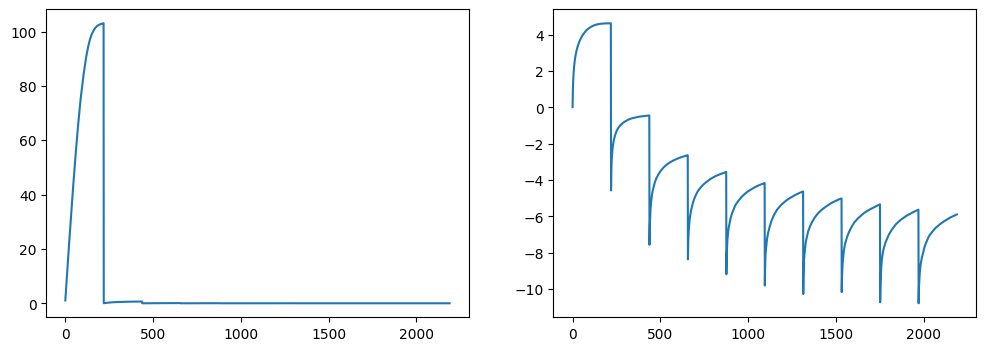

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

#graph is reversed because of the way we append to losses so reverse it 

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].plot(losses[::-1])
# axs[1].plot(np.log(losses[::-1]))
# plt.show()


In [46]:
print("dataset[0]: ", dataset[0])
print("test_set[0]: ", test_set[0])

dataset[0]:  (tensor([-1., -1., -1., -1.,  1.,  1.,  1.,  1.]), tensor(1.))
test_set[0]:  (tensor([1., 1., 1., 1., 0., 0., 0., 0.]), tensor(0.))


## Validation and Testing

In [47]:
# Test the model
test_loss = 0
with torch.no_grad():
    for sequence, condition in convert_dataset(test_set):
        # print("sequence: ", sequence)
        # print("condition: ", condition)
        sequence_tensor = sequence.to(device)
        condition_tensor = condition.to(device)

        optimizer.zero_grad()
        model_output = model(sequence_tensor, condition)
        test_loss += loss_function(model_output, sequence_tensor).item()
test_loss /= len(test_set)

print("Test loss:", test_loss)


# sample the diffusion model

Test loss: 0.0244103562766767


### Generate Sample Data

current_sample:  tensor([ 0.7912,  0.9281, -1.0000,  1.0000, -0.4350,  0.8473,  0.3690, -0.3965])
condition:  tensor(0)
[[ 0.9970822   0.9979335   0.9958481   0.99786687 -0.9964652  -0.9955732
  -0.99653953 -0.99838614]]


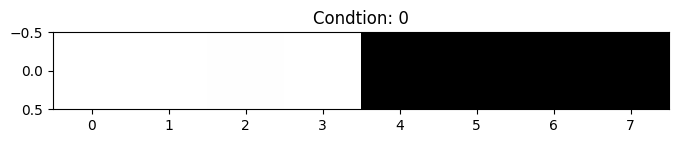

tensor([[ 1.,  1.,  1.,  1., -1., -1., -1., -1.]])


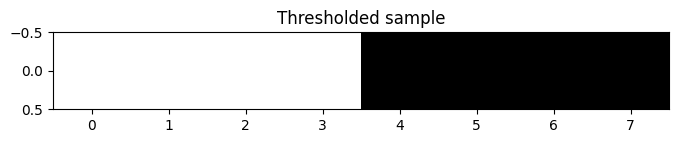

In [66]:
condition = torch.tensor(0).to(device)  # Condition to generate a sample for

num_steps = 1000  # Number of steps in the reverse process
# Start with noise clipped to [-1, 1]
current_sample = torch.clamp(torch.randn(8), -1, 1).to(device)

print("current_sample: ", current_sample)
print("condition: ", condition)


for step in range(num_steps):
    # Apply the model to denoise the sample
    denoised_sample = model(current_sample, condition)

    # Update the current sample with the denoised version
    current_sample = denoised_sample
    #if step % 1 == 0: print(f"Step: {step}, Sample: {denoised_sample}")

# After the loop, current_sample is your generated sample
generated_sample = current_sample
#remove the condition from the generated sample

print(generated_sample.detach().numpy())

title = "Condtion: " + str(condition.item())
visualize_sequence(generated_sample.detach().numpy(), title=title)

#visualize the thresholded sample ()
thresholded_sample = torch.where(generated_sample > 0, torch.ones_like(generated_sample), -torch.ones_like(generated_sample))
print(thresholded_sample)
visualize_sequence(thresholded_sample.detach().numpy(), title="Thresholded sample")


## What Next?

#### 1. Conditioning in the loss
Although I have a conditional loss in place, it might need more refinement to actually guide the model. Making sure that the loss function accurately penalizes deviations is crucial. Also, I can explore different forms of conditional loss, such as weighted loss components or incorporating other metrics that better capture the desired conditioning effect.

#### 2. Conditioning the architecture more/differently
The existing model architecture integrates conditioning information at the input and before the decoder. Exploring alternative methods of integrating conditioning, such as conditional batch normalization or instance normalization, could potentially help especially for categorical conditions

#### 3. Regularization based on conditioning
Introducing a regularization term to the loss function might encourage the model to generate outputs that align more closely with the provided conditions

#### 4. Sampling Strategy
The current sampling strategy  begins with a noise vector and iteratively refines it. That might not be sensitive enough to the conditioning information. Adjusting the initial noise distribution or the update step based on the condition could enhance the model's responsiveness to the conditioning. Could also be a problem with the fact that the diffusion model converges very very quickly.

#### 5. Techniques
According to a stackoverflow post, techniques like feature visualization or intermediate layer analysis could help understand how the condition is being processed to see if its worth 